# Survivor Data Modeling

### Import Dependencies

In [195]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, LeaveOneGroupOut
from sklearn.preprocessing import LabelEncoder
from sklearn.exceptions import DataConversionWarning

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import sys
import warnings
import math
import os
import random

warnings.filterwarnings("ignore", category=DataConversionWarning)

# Get the current working directory
current_dir = os.getcwd()

# Get the path to the survivorData directory
data_dir = os.path.join(current_dir, '..', 'survivorData')

### Read in csv files as Dataframes

In [196]:
# List of CSV file names
csv_files = [
    'advantage_movement.csv',
    'boot_mapping.csv',
    'castaways.csv',
    'castaway_details.csv',
    'challenge_description.csv',
    'challenge_results.csv',
    'confessionals.csv',
    'jury_votes.csv',
    'screen_time.csv',
    'season_palettes.csv',
    'season_summary.csv',
    'survivor_auction.csv',
    'tribe_colours.csv',
    'tribe_mapping.csv',
    'viewers.csv',
    'vote_history.csv'
]

# Create a dictionary to store the DataFrames
dataframes = {}

# Loop through each CSV file and read its data into a DataFrame
for csv_file in csv_files:
    # Specify the relative path to the CSV file
    file_path = os.path.join(data_dir, csv_file)
    
    # Read the data from the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Store the DataFrame in the dictionary
    dataframes[csv_file] = df

# Clean up the data and feature engineering

The final dataset used after initial feature engineering contains 30 columns. The castaways.csv and castaway_details.csv files were merged to create the main dataframe used. As part of the feature engineering process, the "result" column was converted to a categorical variable. In addition, a new "genderNumber" column was created with encoded values 3, 2, 1, 0 representing Male, Female, Non-Binary, and Other categories from the "gender" column. Similarly, a new "won" column was created from the "result" column with encoded values 1 and 0 representing if a contestant was the Sole Survivor (1) or not (0). From the challenge_results.csv file, the total number of immunity wins per contestant were counted and a new column "immunityWins" was added to the dataframe castawayAll. Finally, the dataframe was split into a separate list of dataframes by season.

In [197]:
# Convert tribe_status column to category type
dataframes['tribe_colours.csv']['tribe_status'] = dataframes['tribe_colours.csv']['tribe_status'].astype('category')

# Convert result to a categorical variable
dataframes['castaways.csv']['result'] = pd.Categorical(dataframes['castaways.csv']['result'])
dataframes['castaways.csv']['result'] = dataframes['castaways.csv']['result'].cat.codes

# Merge challenge_results and castaway_details dataframes on castaway_id
castawayAll = pd.merge(dataframes['castaways.csv'], dataframes['castaway_details.csv'], on='castaway_id', how ="left")

castawayAll['genderNumber'] = np.where(castawayAll['gender'] == 'Male', 1,
                                     np.where(castawayAll['gender'] == 'Female', 2,
                                              np.where(castawayAll['gender'] == 'Non-binary', 3, 0)))
castawayAll['won'] = np.where(castawayAll['result'] == 'Sole Survivor', 1, 0)

castawayAll = castawayAll.dropna(subset=['age'])

# Drop rows where 'season' is equal to 44
castawayAll = castawayAll[castawayAll['season'] != 44]

print(castawayAll['castaway_id'])

0       AU0001
1       AU0002
2       AU0003
3       AU0004
4       AU0005
         ...  
1181    US0636
1182    US0634
1183    US0642
1184    US0627
1185    US0638
Name: castaway_id, Length: 1186, dtype: object


### Feature engineering for challenge results data

In [198]:
# Read the challenge_results.csv file
challenge_results = dataframes['challenge_results.csv']

# Filter out the rows where challenge_type is "Immunity" and the result is "Won"
immunity_wins = challenge_results[(challenge_results['challenge_type'] == 'Immunity') & (challenge_results['result'] == 'Won')]

# Group by 'castaway_id' and count the number of immunity wins
immunity_counts = immunity_wins.groupby('castaway_id').size()

# Convert Series to DataFrame
immunity_counts_df = immunity_counts.reset_index(name='immunityWins')

# Set 'castaway_id' as the index for easier merging later
immunity_counts_df.set_index('castaway_id', inplace=True)

# Set 'castaway_id' as the index for 'castawayAll' dataframe for easier merging
castawayAll.set_index('castaway_id', inplace=True)

# Merge 'immunity_counts_df' into 'castawayAll'
castawayAll = castawayAll.merge(immunity_counts_df, how='left', left_index=True, right_index=True)

# Fill NaN values with 0 - assuming that contestants who didn't win any immunity challenges are not present in the immunity_counts_df DataFrame
castawayAll['immunityWins'].fillna(0, inplace=True)

# Print out the column names
print("Columns in the DataFrame:")
print(castawayAll.columns)

# Print out how many people got each number of immunity wins
print("\nNumber of immunity wins for contestants:")
print(castawayAll['immunityWins'].value_counts())

# Print out details about the top 10 castaways with the most immunity wins
top_immunity_winners = castawayAll.nlargest(10, 'immunityWins')
print("\nTop 10 contestants with the most immunity wins:")
print(top_immunity_winners[['full_name_x', 'age', 'city', 'state', 'immunityWins']])

# Once implemented, we can add this data to the x_train but x_test will have to be updated between each guess
# # When creating your training and testing datasets, you should now include 'immunityWins' as a feature
# x_train = pd.concat([season_split[i][['age', 'genderNumber', 'immunityWins']] for i in train_index])
# x_test = pd.concat([season_split[i][['age', 'genderNumber', 'immunityWins']] for i in test_index])



Columns in the DataFrame:
Index(['version', 'version_season', 'season_name', 'season', 'full_name_x',
       'castaway_x', 'age', 'city', 'state', 'episode', 'day', 'order',
       'result', 'jury_status', 'original_tribe', 'result_number',
       'full_name_y', 'full_name_detailed', 'castaway_y', 'date_of_birth',
       'date_of_death', 'gender', 'race', 'ethnicity', 'poc', 'occupation',
       'personality_type', 'genderNumber', 'won', 'immunityWins'],
      dtype='object')

Number of immunity wins for contestants:
3.0     180
0.0     167
2.0     151
1.0     150
4.0     128
5.0      87
6.0      86
7.0      44
10.0     34
9.0      33
8.0      33
11.0     15
14.0     15
12.0     15
15.0     10
13.0      9
18.0      7
16.0      7
21.0      7
17.0      6
20.0      2
Name: immunityWins, dtype: int64

Top 10 contestants with the most immunity wins:
               full_name_x  age       city          state  immunityWins
castaway_id                                                            

### Create a dataframe for each season of the show

In [199]:
# Split dataframe into a list of dataframes grouped by column name
def split_dataframe(df, column_name):
    groups = df.groupby(column_name)
    result = [group for _, group in groups]
    return result

# Call split_dataframe on column name "version_season"
season_split = split_dataframe(castawayAll, 'version_season')

# Give each contestant which order they were eliminated from the show
for df in season_split:
    df['orderOut'] = range(1, len(df) + 1)

# Modeling using classification and regression

### Regression
Predicting the order of elimination in a game such as Survivor using regression techniques can be challenging due to several reasons. Firstly, the game inherently involves a substantial degree of randomness and human unpredictability. It's not just the contestants' age or gender that determines the order of elimination, but also their social interactions, alliances, individual strategies, physical strength, and even luck, factors that are difficult to quantify and capture in a data model. Secondly, the amount of data available for each contestant is quite limited, which makes it difficult for a machine learning model to discern complex patterns and relationships that might help in making more accurate predictions.

### Classification
On the other hand, the simulation modeling approach is expected to perform better because it leverages additional information and context as the game progresses. In this approach, after each round, the model is updated with information about who got eliminated, allowing it to make more informed predictions for the next round. This method inherently reflects the dynamic nature of the game more accurately, capturing changes in game dynamics that can occur after each elimination. Adding information about the number of immunity challenges won could provide an even more substantial boost to the model's performance, as immunity wins are a crucial part of the game and directly affect the elimination process. This continuous learning and adaptation provide the simulation model a clear advantage over a one-shot prediction model like regression.

# Using regression for predicting order out at the start of the show 

In [200]:
def predict_elimination_order(df):
    # Prepare the data
    features = df[['age', 'genderNumber']]
    target = df['orderOut']

    # Initialize the model
    model = RandomForestRegressor()
    
    # Train the model
    model.fit(features, target)

    # Make predictions
    predictions = model.predict(features)

    # Calculate the root mean square error (RMSE)
    rmse = mean_squared_error(target, predictions, squared=False)

    print(f"Root Mean Square Error: {rmse}")
    
    # Return the order of elimination predictions
    return predictions

for i, df in enumerate(season_split):
    print(f"Predicting for season {i+1}")
    predicted_order = predict_elimination_order(df)
    print(predicted_order)

Predicting for season 1
Root Mean Square Error: 4.2197994440692375
[ 4.21        5.27        6.72916667  4.32        9.92       13.79266667
 13.39040476 10.544      14.94233333 10.065      13.37657143 15.0425
 13.31340476 13.39040476 12.43333333 11.93       13.37657143 19.4015
 13.39040476 14.94233333 19.4015     13.79266667 16.74       21.758     ]
Predicting for season 2
Root Mean Square Error: 4.058740192030968
[ 9.3095      5.284       4.59        6.21916667 11.109      14.20703175
  7.66566667  7.36333333  6.21916667 11.3125     13.405      14.20703175
 11.3125     11.109      17.88        9.3095     15.046      15.5015
 17.0225     18.955      18.22788889 18.83       14.20703175 21.16      ]
Predicting for season 3
Root Mean Square Error: 4.254637703383469
[ 5.1        11.64666667  9.23       10.09        5.37833333  8.14133333
  8.14133333 11.64       13.44666667 14.31       14.37       11.067
 12.87666667 13.77947619 16.07514286 16.68       16.07514286 17.91666667
 15.72116667 

# Simulation of survivor seasons and predicting the order in which people leave the game

The simulation model employed in this code is well-suited for the given dataset, which corresponds to the TV show Survivor. In Survivor, contestants are eliminated one by one, and an obvious objective is to predict the next person who will leave the show. To ensure accurate predictions, it is crucial to consider only the remaining contestants at each stage, as those who have already been eliminated would not contribute to the decision-making process.

The code implements a leave-one-group-out cross-validation technique, which aligns with the Survivor format. Each iteration of the cross-validation loop represents a new stage of the show, where a group of contestants is considered for prediction while excluding the others who have already been eliminated. This simulation approach ensures that the predictions are based on the available pool of contestants, mimicking the progression of the actual show.

By training and evaluating the SVM and logistic regression models on the remaining contestants in each iteration, the simulation model captures the dynamic nature of Survivor, where the characteristics and interactions among the remaining contestants influence the prediction outcomes. The model predicts the "orderOut" values (the order of elimination) for the test set, and the accuracy of the predicted outcomes is calculated against the true outcomes.

Overall, this simulation model ideologically aligns with Survivor by accounting for the evolving dynamics of the show, focusing on the remaining contestants, and predicting their order of elimination. It ensures that predictions are based on the relevant subset of contestants and provides a practical and effective approach for forecasting the outcomes in the context of the TV show Survivor.

### Status of capabilities

The provided code is still a work in progress and requires further refinement to ensure accurate incorporation of the concept of considering only the remaining contestants at each stage. Adjustments and modifications are needed to improve the code's adherence to the elimination rules of the Survivor show.

Additionally, fine-tuning the model's parameters and implementing appropriate data preprocessing techniques are essential steps to enhance the accuracy of the predictions. While progress has been made in filtering out eliminated contestants from the prediction process, further testing and evaluation are necessary to ensure the logic is robust and reliable.

Another important aspect that requires attention is the handling of missing or incomplete data. Devising effective strategies to address missing values and ensuring the completeness of the dataset will contribute to more accurate predictions.

Ongoing development and iterative improvements are crucial to align the simulation model more closely with the actual progression of the Survivor TV show. Through these efforts, meaningful insights can be provided, enabling better predictions of the order of elimination

In [201]:
# Use a random forest model that tries to predict the order the remaining contestants will be eliminated from the show.
#       Return the contestant remaining that has the lowest orderOut prediction
#       An orderOut value of 1 means that person was the first eleminated and the hightest orderOut in that season is the winner
#       x_train is the age and gender of contestants in the training set
#       y_train is the orderOut for contestants in the training set
#       current_order is the orderOut value that is being predicted
def person_prediction_random_forest(remaining_contestants, x_train_current, y_train_current, current_order):
    # Train the random forest model
    model = RandomForestClassifier()
    model.fit(x_train_current, y_train_current)

    # Predict the order for the remaining contestants
    x_test_current = remaining_contestants[['age', 'genderNumber']]
    predicted_order = model.predict(x_test_current)

    # Find the contestants with the smallest predicted order
    min_predicted_order = np.min(predicted_order)
    contestants_with_min_order = np.where(predicted_order == min_predicted_order)[0]

    # Randomly select one contestant from those with the smallest predicted order
    person_predicted = np.random.choice(contestants_with_min_order)

    return person_predicted

def person_prediction_support_vector_machine(remaining_contestants, x_train_current, y_train_current, current_order):
    # Train the support vector machien model using a "one-vs-rest" decision function shape
    model = svm.SVC(decision_function_shape='ovo')
    model.fit(x_train_current, y_train_current)

    # Predict the order for the remaining contestants
    x_test_current = remaining_contestants[['age', 'genderNumber']]
    predicted_order = model.predict(x_test_current)

    # Find the contestants with the smallest predicted order
    min_predicted_order = np.min(predicted_order)
    contestants_with_min_order = np.where(predicted_order == min_predicted_order)[0]

    # Randomly select one contestant from those with the smallest predicted order
    person_predicted = np.random.choice(contestants_with_min_order)

    return person_predicted

# NOT WORKING
# This is run after each person is eliminated 
def generate_challenge_features(challenge_results, current_season, current_episode):
    # Filter the rows for the current season and episode
    # current_results = challenge_results[(challenge_results['season'] == current_season) & (challenge_results['episode'] == current_episode)]
    
    # # Generate recent_challenge_result
    # current_results['recent_challenge_result'] = current_results['result'].map({'Won': 1, 'Lost': 0})
    
    # # Generate total_wins_so_far
    # total_wins = challenge_results[(challenge_results['season'] == current_season) & (challenge_results['episode'] <= current_episode) & (challenge_results['result'] == 'Won')].groupby('castaway_id').size()
    # total_wins_df = total_wins.reset_index(name='total_wins_so_far')
    
    # # Merge recent_challenge_result and total_wins_so_far into current_results
    # current_results = current_results.merge(total_wins_df, how='left', on='castaway_id')
    # current_results['total_wins_so_far'].fillna(0, inplace=True)
    
    # return current_results[['castaway_id', 'recent_challenge_result', 'total_wins_so_far']]
    return challenge_results

In [202]:
# Perform leave-one-group-out cross-validation
logo = LeaveOneGroupOut()

# Create a list of group labels corresponding to each DataFrame in season_split
group_labels = [i for i, _ in enumerate(season_split)]

# print(len(season_split))
# print(len(group_labels))

accuracies_random_forest = []  # Create an empty list to store accuracies

for train_index, test_index in logo.split(season_split, groups=group_labels):

    x_train = pd.concat([season_split[i][['age', 'genderNumber']] for i in train_index])
    y_train = pd.concat([season_split[i][['orderOut']] for i in train_index])

    x_test = pd.concat([season_split[i][['age', 'genderNumber']] for i in test_index])
    y_test = pd.concat([season_split[i][['orderOut']] for i in test_index])

    number_of_contestants = len(x_test)
    order_out = 1
    correct_predictions = 0

    while len(x_test) > 0:
        age_eliminated = x_test.iloc[0]['age']
        gender_number_eliminated = x_test.iloc[0]['genderNumber']
        
        # Select a person
        prediction_person_index = person_prediction_random_forest(x_test, x_train, y_train, order_out)
        
        # print("-------------------------------------")
        # print(f"Person prediction position: {prediction_person_index}")
        # print(f"Person prediction age: {x_test.iloc[prediction_person_index]['age']}")
        
        # print(f"Person eleminated position: {prediction_person_index}")
        # print(f"Person eleminated age: {age_eliminated}")
        # print("-------------------------------------")
        
        # Check if the prediction is correct
        if prediction_person_index == 0:
            correct_predictions += 1
        
        # Remove the first element of x_test
        x_test = x_test.iloc[1:]
        order_out = order_out + 1
        
        current_season = 0
        current_episode = 0
        
        # Update x_test to include updated challenge results
        challenge_features = generate_challenge_features(x_test, current_season, current_episode)
        # x_test = x_test.merge(challenge_features, how='left', on='castaway_id')

    # Calculate and print the accuracy of the model
    # print("----------")
    # print(number_of_contestants)
    accuracy = (correct_predictions / number_of_contestants) * 100
    accuracies_random_forest.append(accuracy)
    # print(f"Model Accuracy: {accuracy}%")
    # print("----------")
    
# print(x_test)
# print(y_test)
print(accuracies_random_forest)


[12.5, 8.333333333333332, 12.0, 16.0, 25.0, 15.384615384615385, 7.142857142857142, 16.0, 31.57894736842105, 31.25, 25.0, 5.555555555555555, 21.052631578947366, 20.0, 22.22222222222222, 14.285714285714285, 5.0, 15.0, 31.25, 18.75, 18.75, 12.5, 31.25, 25.0, 22.22222222222222, 22.22222222222222, 16.666666666666664, 25.0, 11.11111111111111, 31.25, 15.0, 10.526315789473683, 18.75, 15.0, 22.22222222222222, 18.75, 15.0, 20.0, 25.0, 20.0, 10.0, 16.666666666666664, 16.666666666666664, 15.0, 8.695652173913043, 27.77777777777778, 16.666666666666664, 16.666666666666664, 15.0, 22.22222222222222, 15.0, 15.0, 22.22222222222222, 10.0, 15.0, 10.0, 20.0, 13.636363636363635, 16.666666666666664, 11.11111111111111, 22.22222222222222]


In [203]:
# Perform leave-one-group-out cross-validation
logo = LeaveOneGroupOut()

# Create a list of group labels corresponding to each DataFrame in season_split
group_labels = [i for i, _ in enumerate(season_split)]

# print(len(season_split))
# print(len(group_labels))

accuracies_support_vector_machine = []  # Create an empty list to store accuracies

for train_index, test_index in logo.split(season_split, groups=group_labels):

    x_train = pd.concat([season_split[i][['age', 'genderNumber']] for i in train_index])
    y_train = pd.concat([season_split[i][['orderOut']] for i in train_index])

    x_test = pd.concat([season_split[i][['age', 'genderNumber']] for i in test_index])
    y_test = pd.concat([season_split[i][['orderOut']] for i in test_index])

    number_of_contestants = len(x_test)
    order_out = 1
    correct_predictions = 0

    while len(x_test) > 0:
        age_eliminated = x_test.iloc[0]['age']
        gender_number_eliminated = x_test.iloc[0]['genderNumber']
        
        # Select a person
        prediction_person_index = person_prediction_support_vector_machine(x_test, x_train, y_train, order_out)
        
        # print("-------------------------------------")
        # print(f"Person prediction position: {prediction_person_index}")
        # print(f"Person prediction age: {x_test.iloc[prediction_person_index]['age']}")
        
        # print(f"Person eleminated position: {prediction_person_index}")
        # print(f"Person eleminated age: {age_eliminated}")
        # print("-------------------------------------")
        
        # Check if the prediction is correct
        if prediction_person_index == 0:
            correct_predictions += 1
        
        # Remove the first element of x_test
        x_test = x_test.iloc[1:]
        order_out = order_out + 1
        
        current_season = 0
        current_episode = 0
        
        # Update x_test to include updated challenge results
        challenge_features = generate_challenge_features(x_test, current_season, current_episode)
        # x_test = x_test.merge(challenge_features, how='left', on='castaway_id')

    # Calculate and print the accuracy of the model
    # print("----------")
    # print(number_of_contestants)
    accuracy = (correct_predictions / number_of_contestants) * 100
    accuracies_support_vector_machine.append(accuracy)
    # print(f"Model Accuracy: {accuracy}%")
    # print("----------")
    
# print(x_test)
# print(y_test)
print(accuracies_support_vector_machine)


[12.5, 16.666666666666664, 12.0, 16.0, 12.5, 23.076923076923077, 10.714285714285714, 12.0, 26.31578947368421, 25.0, 12.5, 5.555555555555555, 15.789473684210526, 30.0, 5.555555555555555, 19.047619047619047, 15.0, 15.0, 6.25, 18.75, 31.25, 18.75, 31.25, 31.25, 22.22222222222222, 16.666666666666664, 16.666666666666664, 10.0, 22.22222222222222, 12.5, 15.0, 15.789473684210526, 25.0, 10.0, 11.11111111111111, 31.25, 25.0, 15.0, 20.0, 20.0, 15.0, 33.33333333333333, 5.555555555555555, 5.0, 21.73913043478261, 11.11111111111111, 22.22222222222222, 16.666666666666664, 20.0, 33.33333333333333, 25.0, 30.0, 16.666666666666664, 10.0, 10.0, 15.0, 30.0, 31.818181818181817, 16.666666666666664, 22.22222222222222, 11.11111111111111]


### Model analysis

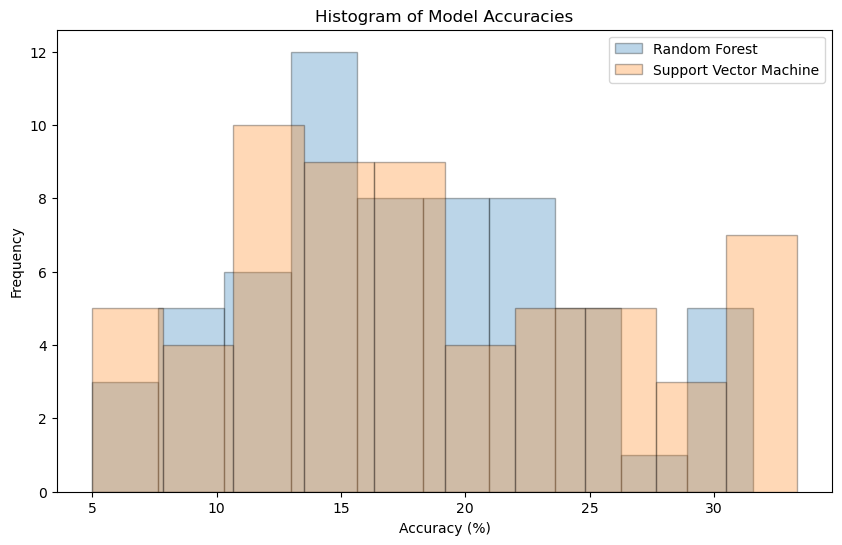

In [222]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10,6))

# Plot histogram for Random Forest model
plt.hist(accuracies_random_forest, bins=10, edgecolor='black', alpha=0.3, label='Random Forest')

# Plot histogram for Support Vector Machine model
plt.hist(accuracies_support_vector_machine, bins=10, edgecolor='black', alpha=0.3, label='Support Vector Machine')

# Set title and labels
plt.title('Histogram of Model Accuracies')
plt.xlabel('Accuracy (%)')
plt.ylabel('Frequency')

# Add a legend
plt.legend()

# Show the plot
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


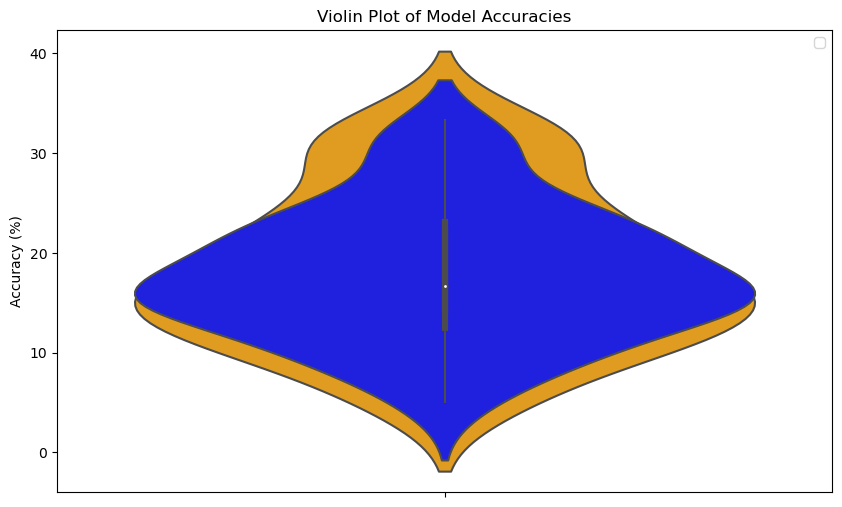

In [225]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10,6))

# Plot violin plot for Support Vector Machine model
sns.violinplot(y=accuracies_support_vector_machine, color='orange', label='Support Vector Machine', alpha=0.1)

# Plot violin plot for Random Forest model
sns.violinplot(y=accuracies_random_forest, color='blue', label='Random Forest', alpha=0.1)

# Set title and labels
plt.title('Violin Plot of Model Accuracies')
plt.ylabel('Accuracy (%)')

# Add a legend
plt.legend()

# Show the plot
plt.show()


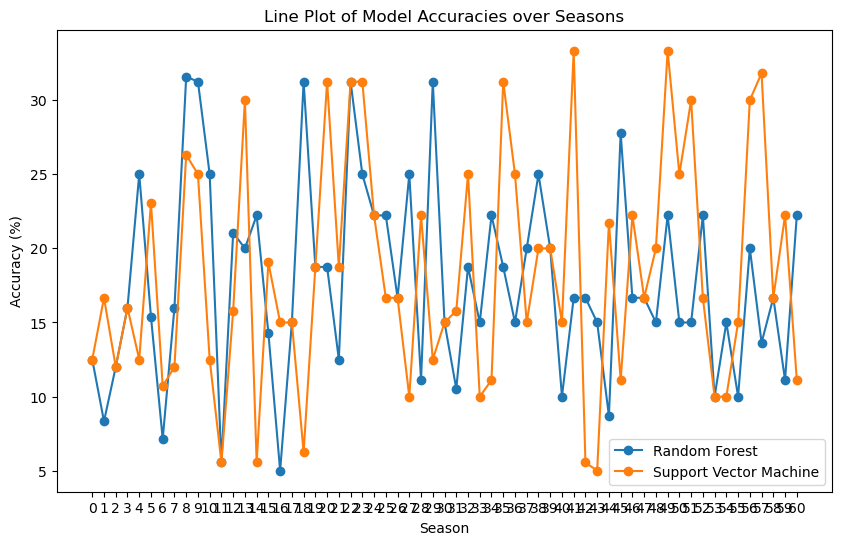

In [219]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10,6))

# Plot accuracies for Random Forest model
ax.plot(range(1, len(accuracies_random_forest) + 1), accuracies_random_forest, marker='o', label='Random Forest')

# Plot accuracies for Support Vector Machine model
ax.plot(range(1, len(accuracies_support_vector_machine) + 1), accuracies_support_vector_machine, marker='o', label='Support Vector Machine')

# Set title and labels
ax.set_title('Line Plot of Model Accuracies over Seasons')
ax.set_xlabel('Season')
ax.set_ylabel('Accuracy (%)')

# Set the x-axis ticks and labels
ax.set_xticks(range(1, len(accuracies_random_forest) + 1))
ax.set_xticklabels(group_labels)

# Add a legend
ax.legend()

# Show the plot
plt.show()


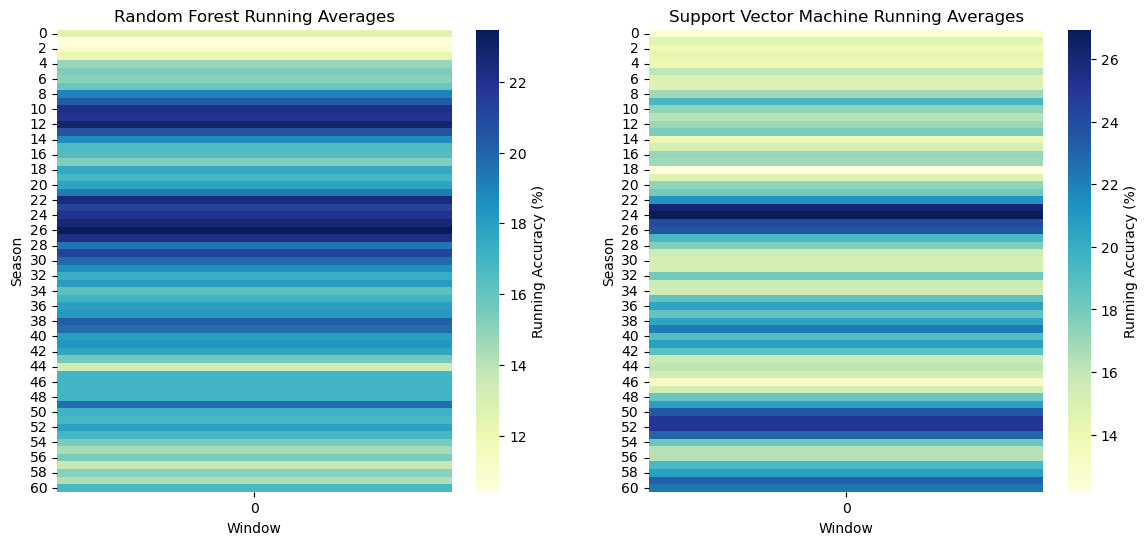

In [218]:
# Compute running averages over a window of 5 seasons
window_size = 5
running_averages_rf = [np.mean(accuracies_random_forest[max(0, i-window_size+1):i+1]) for i in range(len(accuracies_random_forest))]
running_averages_svm = [np.mean(accuracies_support_vector_machine[max(0, i-window_size+1):i+1]) for i in range(len(accuracies_support_vector_machine))]

# Create 2D arrays for the heatmaps
heatmap_data_rf = np.array(running_averages_rf).reshape(-1, 1)
heatmap_data_svm = np.array(running_averages_svm).reshape(-1, 1)

# Create a figure with two subplots side by side
fig, axs = plt.subplots(ncols=2, figsize=(14, 6))

# Plot the heatmaps in their respective subplots
sns.heatmap(heatmap_data_rf, cmap="YlGnBu", cbar_kws={'label': 'Running Accuracy (%)'}, ax=axs[0])
sns.heatmap(heatmap_data_svm, cmap="YlGnBu", cbar_kws={'label': 'Running Accuracy (%)'}, ax=axs[1])

# Set the titles of the subplots
axs[0].set_title('Random Forest Running Averages')
axs[1].set_title('Support Vector Machine Running Averages')

# Set the labels of the subplots
for ax in axs:
    ax.set_xlabel('Window')
    ax.set_ylabel('Season')

plt.show()


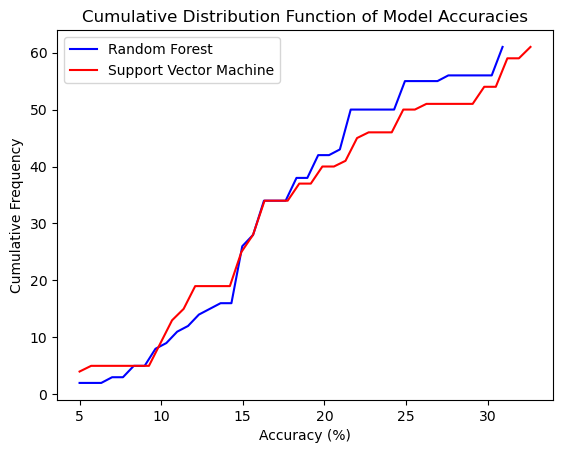

In [217]:
# Compute CDF for Random Forest accuracies
values_rf, base_rf = np.histogram(accuracies_random_forest, bins=40)
cumulative_rf = np.cumsum(values_rf)

# Compute CDF for Support Vector Machine accuracies
values_svm, base_svm = np.histogram(accuracies_support_vector_machine, bins=40)
cumulative_svm = np.cumsum(values_svm)

plt.plot(base_rf[:-1], cumulative_rf, c='blue', label='Random Forest')
plt.plot(base_svm[:-1], cumulative_svm, c='red', label='Support Vector Machine')

plt.title('Cumulative Distribution Function of Model Accuracies')
plt.xlabel('Accuracy (%)')
plt.ylabel('Cumulative Frequency')
plt.legend()  # To distinguish between different lines in the plot
plt.show()


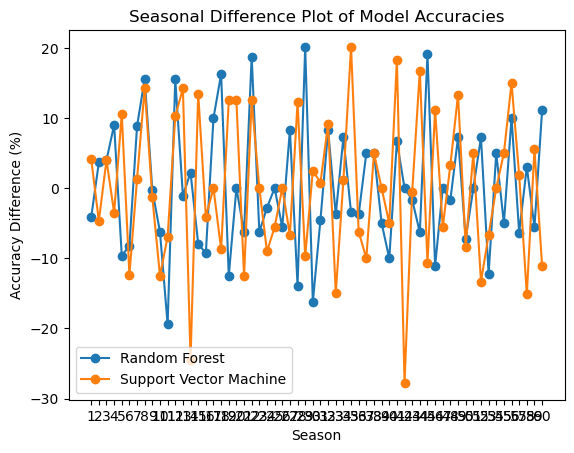

In [216]:
# Compute differences for Random Forest accuracies
differences_rf = [j - i for i, j in zip(accuracies_random_forest[:-1], accuracies_random_forest[1:])]

# Compute differences for Support Vector Machine accuracies
differences_svm = [j - i for i, j in zip(accuracies_support_vector_machine[:-1], accuracies_support_vector_machine[1:])]

plt.plot(range(1, len(differences_rf) + 1), differences_rf, marker='o', label='Random Forest')
plt.plot(range(1, len(differences_svm) + 1), differences_svm, marker='o', label='Support Vector Machine')

plt.title('Seasonal Difference Plot of Model Accuracies')
plt.xlabel('Season')
plt.ylabel('Accuracy Difference (%)')
plt.xticks(ticks=range(1, len(differences_rf) + 1), labels=group_labels[1:])
plt.legend()  # To distinguish between different lines in the plot
plt.show()


# Usefulness of models

Despite a large amount of attributes and instances, we were limited on useful data, especially when trying to make predictions without up to date challenge results. For instance, information that could have been useful like race and personality type have an overwhelming amount of NA’s. We were left with age and gender for our useful attributes without feature engineering up to date challenge or voting results. 
Survivor comes down to luck and social interaction which are unmeasurable attributes. For example, you can be a great puzzle solver or the strongest contestant, but if you have a big ego or aren't good at cultivating friendships, these are always early ways to get voted out. This is important to note when considering the accuracy of the models we ran. None of the models can account for these core attributes of Survivor but we hope to test and uncover insights with what is available.

The code we have is a great starting point for creating more useful models if better data is collected or feature engineered. The models that predict the order at the start of the show can give insight into what attributes to look out for when watching and predicting someone who won't get voted off first. The models that maintain up to date information before each vote will have more informed predictions. 
At the very least this piece of functionality can output relevant up to date information someone might want to look at before making a decision. There is potential prediction power in data such as challenge and voting results. So despite the expected low accuracy of all of the models they could provide useful information and insights into predictions.

# Goals:

1. Unit/Functional Testing: We are aiming to set up more comprehensive testing to verify that the simulation is working as intended. This will involve designing test cases that cover various scenarios and edge cases to ensure the code handles them correctly.

2. Updating x_test DataFrame: We plan to update the x_test DataFrame with data from previous events of the current season such as challenge results.

3. Create visualization to see if there is a relationship between age and likelyhood of being eliminated from the show due to a medical emergency or any other reason besides a vote. If there is a correlation try to leverage this knowledge in models.